This notebook provides an approach to visualize the wearable wear behavior of a single
participant.

> **NOTE**: the findings of this analysis are skewed as the ETRI wearable data is only available for labeled intervals. As such, this notebook more or less provides a label availability analysis instead of a wear behavior analysis.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from code_utils.path_conf import processed_etri_path
from code_utils.utils.interaction_analysis import get_wearable_session_df
from datetime import datetime

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [12]:
# ---------------------------- Hyperparameters ---------------------------- #
USE_PNG = True # whether the figure is displayed via a static image or interactive plot
user = "user08"
W_SIZE_MIN_DAY = 30  # the aggregation window size in minutes for time of day analysis
W_SIZE_MIN_WEEK = 60  # the aggregation window size in minutes for day of week analysis
# ------------------------------------------------------------------------ #

In [13]:
# utilize the wearable temperature data to construct the session dataframe
glob = list((processed_etri_path / user).glob("*Temp*.parquet"))
df_tmp = pd.concat(
    [
        pd.read_parquet(f).set_index("timestamp").rename(columns={"temp": "TMP"})
        for f in glob
    ]
).sort_index()

df_wrist_wearable_sessions = get_wearable_session_df(glob, fs_exp=1)
dt = df_tmp.index[0].replace(hour=0, minute=0, second=0, microsecond=0)

# fmt: off
# derive the daily data ratio
df_res_dr = df_tmp.resample(f'{W_SIZE_MIN_DAY}min').count() / (60 * 4 * W_SIZE_MIN_DAY)
df_time_day_mean = df_res_dr.groupby([df_res_dr.index.hour, df_res_dr.index.minute]).mean()
df_time_day_mean.index = df_time_day_mean.index.map(lambda x: datetime(2021, 1, 1, x[0], x[1]))

# derive the weekly data ratio
df_res_dr = df_tmp.resample(f'{W_SIZE_MIN_WEEK}min').count() / (60 * 4 * W_SIZE_MIN_WEEK)
df_time_week_mean = df_res_dr.groupby([df_res_dr.index.dayofweek, df_res_dr.index.hour, df_res_dr.index.minute]).mean()
df_time_week_mean['dow'] = df_time_week_mean.index.get_level_values(0)  # day of week
df_time_week_mean.index = df_time_week_mean.index.map(lambda x: dt.replace(hour=x[1], minute=x[2]))

  0%|          | 0/26 [00:00<?, ?it/s]

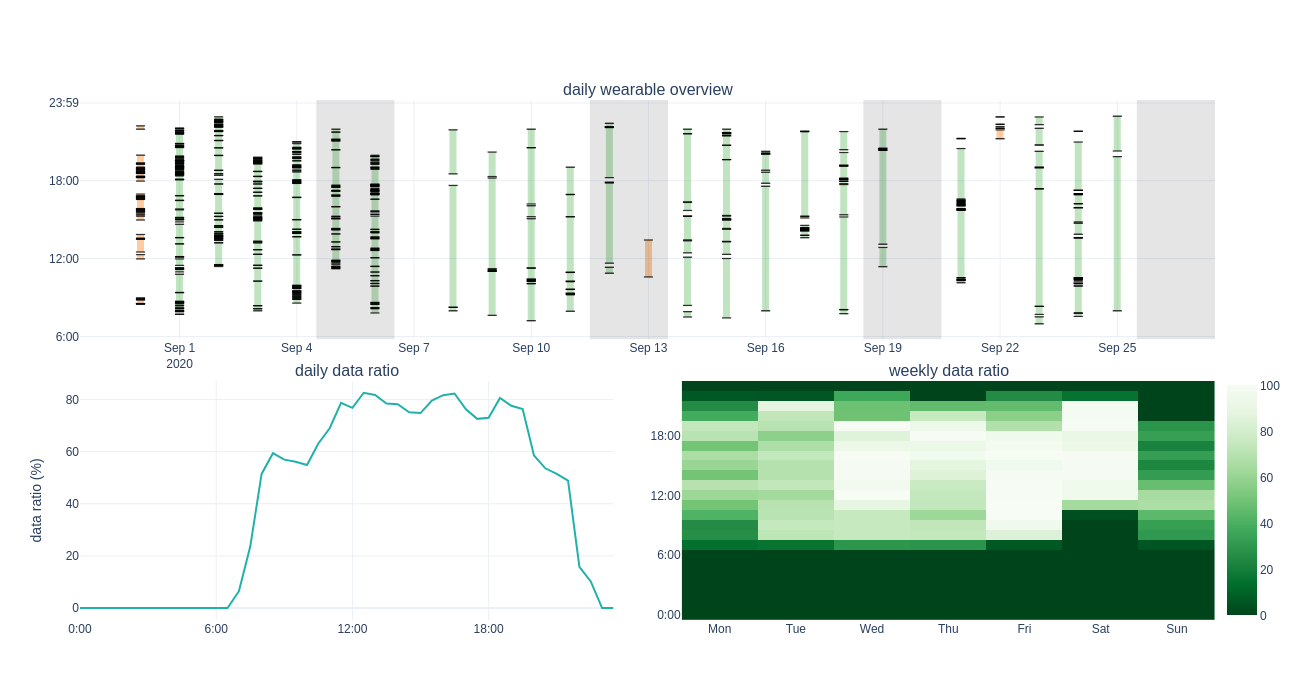

In [14]:
# sampe figure as above, but with the headache events as red rectangles
to_same_date = lambda time: datetime.combine(dt.date(), time)

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{"colspan": 2}, {}], [{}, {}]],
    subplot_titles=[
        "daily wearable overview",
        "",
        "daily data ratio",
        "weekly data ratio",
    ],
    vertical_spacing=0.08,
    horizontal_spacing=0.06,
)
fig.update_layout(template="plotly_white", height=700)

# ---------------------------- Plotting ---------------------------- #
# --------------- row 1: wearable session data
# Add the wearable sessions (vertical interval bars for each day)
for _, session in list(df_wrist_wearable_sessions.iterrows()):
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=6) else ""
    name += f"wearable sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=6)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=7,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=6,
                opacity=0.8,
            ),
            name=name,
            showlegend=False,
            hovertext=f"total daily wear time = {int(hours)}u{int(minutes)}",
        ),
        row=1,
        col=1,
    )


# Shade the weekends (gray shade)
dr = pd.date_range(
    df_tmp.index.date.min(), df_tmp.index.date.max() + pd.Timedelta(days=1), freq="D"
)
for sat in np.unique(dr[dr.dayofweek == 5]):
    fig.add_vrect(
        x0=pd.Timestamp(sat) - pd.Timedelta(hours=12),
        x1=pd.Timestamp(sat) + pd.Timedelta(hours=36),
        fillcolor="rgba(0, 0, 0, .1)",
        line_width=0,
    )

# --------------- row 2 - col 1 - data ratio over time of day
fig.add_trace(
    go.Scatter(
        x=df_time_day_mean.index,
        y=df_time_day_mean["TMP"] * 100,
        name="1min data rate",
        showlegend=False,
        line=dict(color="lightseagreen"),
    ),
    row=2,
    col=1,
)
fig.update_yaxes(title_text="data ratio (%)", row=2, col=1)
dt_0 = df_time_day_mean.index[0]
fig.update_xaxes(
    type="date",
    tickformat="%H:%M",
    tickmode="array",
    ticktext=["0:00", "6:00", "12:00", "18:00", "23:59"],
    tickvals=[
        dt_0.replace(hour=0),
        dt_0.replace(hour=6),
        dt_0.replace(hour=12),
        dt_0.replace(hour=18),
        dt_0.replace(hour=23, minute=59),
    ],
    row=2,
    col=1,
)


# --------------- row 2 - col 2 - data ratio over time of week (heatmaps)
fig.add_trace(
    go.Heatmap(
        z=df_time_week_mean["TMP"] * 100,
        y=df_time_week_mean.index,
        x=df_time_week_mean["dow"],
        zmin=0,
        zmax=100,
        colorscale="greens_r",
        colorbar_len=0.48,
        colorbar_y=0.23,
        colorbar_x=1.002,
    ),
    row=2,
    col=2,
)


# --------------- axis settings
for row, col in [(1, 1), (2, 2)]:
    fig.update_yaxes(
        tickformat="%H:%M",
        tickmode="array",
        ticktext=["0:00", "6:00", "12:00", "18:00", "23:59"],
        tickvals=[
            dt.replace(hour=0),
            dt.replace(hour=6),
            dt.replace(hour=12),
            dt.replace(hour=18),
            dt.replace(hour=23, minute=59),
        ],
        row=row,
        col=col,
    )

fig.update_xaxes(
    tickmode="array",
    tickvals=[0, 1, 2, 3, 4, 5, 6],
    ticktext=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    row=2,
    col=2,
)
# hide the gridlines
fig.update_xaxes(zeroline=False, showgrid=False, row=2, col=2)
fig.update_yaxes(zeroline=False, showgrid=False, row=2, col=2)

# display the figure
if USE_PNG:
    fig.show(renderer="png", width=1300, height=700)
else:
    fig.show()

Based on the above figure, we observe a high daytime ratio availability between 7AM and 8PM (which are the daytime periods in which participants can label).

Sundays and Mondays seem to be the days that with the lowest label availability.